Goal:

* make figure showing how `patience` makes Hyperband scale

Figures to accomplish that:

* num_workers vs time_to_completion
* specific: one random_state, two vertical graphs showing number of workers and num_workers

Show:

1. scaling
2. patience
3. time to accuracy

This means:

* mean accuracy over time (1)
* activity over time for `patience in [True, False]` (in vertical graphs)


* time to accuracy for one set of workers
    * show patience in this graph too
* time to completion for different workers

In [1]:
import pandas as pd

In [2]:
def fname(workers, random_state, patience):
    return f"-workers={workers}-rs={random_state}-patience={patience}"

import numpy as np
import datetime

def _get_summary(row):
    out = []
    for x in row.startstops:
        out.append([row.worker_id, row["key"], x[0], x[1], x[2]])
    return out
def tasks_running(time, logs):
    task_running = (logs.start < time) & (time < logs.stop)
    return task_running.sum()

from copy import copy
def _get_df(today, random_state, workers, patience, verbose=False, plot=False):
    _num_workers = copy(workers)
    df1 = pd.read_msgpack(today + fname(workers, random_state, patience) + "-times.msgpack")
    df1["worker_id"] = df1.worker.apply(hash)
    print("Unique workers =", len(df1.worker_id.unique()))

    out = df1[["worker_id", "startstops", "key"]].apply(
        _get_summary,
        axis=1
    )
    if verbose:
        print(len(out))
    out = list(out)
    if verbose:
        print(len(out))
    out = sum(out, [])
    if verbose:
        print(len(out))
    df = pd.DataFrame(out, columns=["worker_id", "key", "task", "start", "stop"])
    df["duration"] = df["stop"] - df["start"]
    times = df.groupby("task")["duration"].agg(["min", "mean", "median", "max"])
    if verbose:
        print(times)
    if plot:
        _ = df.groupby("task")["duration"].plot.hist()
    
    show = df[df.task == "compute"]
    model_creation = show["key"].apply(lambda x: "_create_model" in x)
    start_time = show[model_creation].stop.max()
    show = show[show.stop > start_time]
    
    times = np.linspace(show.start.min(), show.stop.max(), num=100)
    num_workers = [{"time": t, "active_workers": tasks_running(t, show), "datetime": datetime.datetime.fromtimestamp(t)}
                   for t in times]
    
    workers = pd.DataFrame(num_workers)
    workers["elapsed_time"] = workers.time - workers.time.min()
    workers["patience"] = patience
    workers["random_state"] = random_state
    workers["num_workers"] = _num_workers
    return workers

Unique workers = 16
5471
5471
6354
                  min      mean    median       max
task                                               
compute      0.000008  1.035881  1.043926  1.539468
deserialize  0.145977  0.145977  0.145977  0.145977
transfer     0.002848  0.203697  0.172308  1.151982


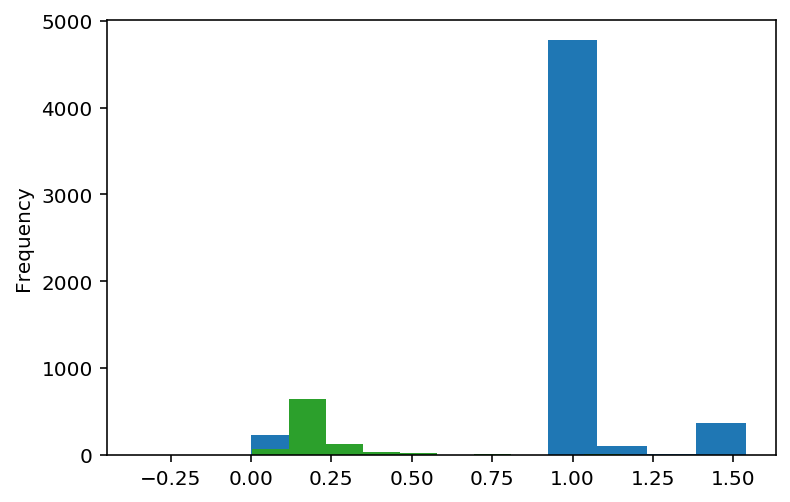

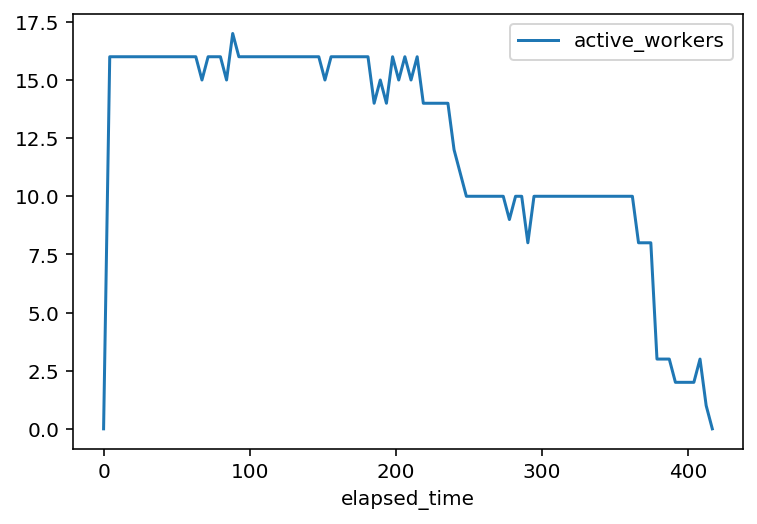

In [3]:
today = "sim/2019-06-28-"

workers = 16
patience = False
rs = 401

df = _get_df(today, rs, workers, patience, verbose=True, plot=True)
df.plot(x="elapsed_time", y="active_workers")

In [19]:
workers = 16
patience = False
# rs = 402
rs = 403
# rs = 404
# rs = 405
# rs = 401
# rs = 400

dfs = [
    _get_df(today, rs, workers, patience, verbose=False, plot=False)
    for workers in [4, 8, 16, 24, 32]
    for patience in [True, False]
]

Unique workers = 4
Unique workers = 4
Unique workers = 8
Unique workers = 8
Unique workers = 16
Unique workers = 16
Unique workers = 24
Unique workers = 24
Unique workers = 32
Unique workers = 32


In [20]:
df = pd.concat(dfs)

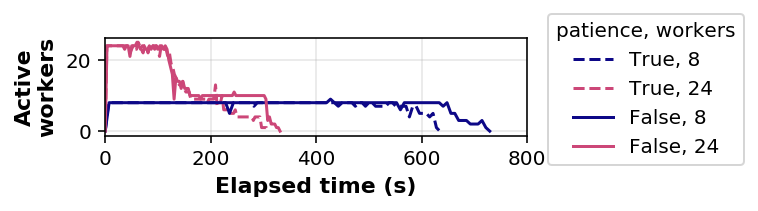

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

w = 0.9
fig, ax = plt.subplots(nrows=1, figsize=(4.2 * w, w))

def c(x, cmap="plasma"):
    return getattr(cm, cmap)(x)

n = 4
colors = {8: c(0), 16: c(1 / n), 24: c(2 / n), 32: c(3 / n)}
styles = {True: "--", False: "-"}

for patience in [True, False]:
    for num_workers in [8, 24]:
        show = df[(df.num_workers == num_workers) & (df.patience == patience)]
        ax.plot(
            show.elapsed_time,
            show.active_workers,
            styles[patience],
            color=colors[num_workers],
            label=f"{patience}, {num_workers}"
        )
        
ax.grid(alpha=0.3)
# ax.set_ylabel("Active" + " " * 12 + "\nworkers" + " " * 12, rotation=0)
fontdict = {"weight": "bold", "fontsize": 11}
ax.set_ylabel("Active\nworkers", fontdict=fontdict)
ax.legend(loc=(1.05, -0.3), title="patience, workers")
ax.set_xlabel("Elapsed time (s)", fontdict=fontdict)
ax.set_xlim(0, 800)
plt.savefig("figs/patience.pdf", bbox_inches="tight")